In [1]:
from importlib import reload
from os.path import join
from collections import defaultdict
import sys
import numpy as np
import cv2
cv2.setNumThreads(1)
import os

In [2]:
import ipywidgets
from IPython.display import display, clear_output
from matplotlib import pyplot

In [3]:
from datasets.dshdf5pose import Hdf5PoseDataset
import datatransformation
import neuralnets.models as models
import vis
import utils
import train
from datasets.infinitelyrepeatinginterleaveddatasets import InfinitelyRepeatingInterleavedDatasets

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as tf
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset
from torchvision import transforms

In [5]:
inputsize = 129
datadir = os.environ['DATADIR']

augment = [
    datatransformation.ApplyRoiRandomized(),
    datatransformation.Rescale((inputsize,inputsize)),
    datatransformation.AdaptiveBrightnessContrastDistortion(),
    datatransformation.Flip(),
]
testpreprocess = [
    datatransformation.ApplyRoi(),
    datatransformation.Rescale(inputsize+1),
    datatransformation.CenterCrop(inputsize),
]
normalize_and_tensor = [
    datatransformation.Normalize(monochrome=True),
    datatransformation.ToTensor()
]

ds_train_aflw = Hdf5PoseDataset(join(datadir,'aflw2k.h5'), shuffle=True, subset=slice(400,None), transform=transforms.Compose([
    datatransformation.InjectPt3d68Enable(),
    datatransformation.InjectPoseEnable(),
    *augment,
    *normalize_and_tensor
]))

ds_full_300wlp = Hdf5PoseDataset(join(datadir,'300wlp.h5'), shuffle=True, transform=transforms.Compose([
    datatransformation.InjectPt3d68Enable(),
    datatransformation.InjectPoseEnable(),
    *augment,
    *normalize_and_tensor
]))

ds_full_ytfaces = Hdf5PoseDataset(join(datadir,'ytfaces.h5'), shuffle=True, transform=transforms.Compose([
    datatransformation.InjectZeroPose(),
    datatransformation.InjectPt3d68Enable(),
    *augment,
    *normalize_and_tensor
]))


ds_test_biwi = Hdf5PoseDataset(join(datadir,'biwi.h5'), shuffle=True, subset=None, transform=transforms.Compose([
    datatransformation.InjectZeroKeypoints3d(),
    datatransformation.InjectPoseEnable(),
    *testpreprocess,
    *normalize_and_tensor
]))

ds_test_aflw = Hdf5PoseDataset(join(datadir,'aflw2k.h5'), shuffle=False, subset=slice(400), transform=transforms.Compose([
    datatransformation.InjectPt3d68Enable(),
    datatransformation.InjectPoseEnable(),
    *testpreprocess,
    *normalize_and_tensor
]))

In [6]:
print ("Train ds sizes: ", [len(ds) for ds in [ds_train_aflw, ds_full_300wlp, ds_full_ytfaces]])

Train ds sizes:  [1600, 61225, 260399]


In [7]:
ds_test = ds_test_aflw

#ds_train = ds_train_aflw
ds_train = InfinitelyRepeatingInterleavedDatasets(
    32*1024, 
    [ds_train_aflw, ds_full_ytfaces, ds_full_300wlp], 
    [1., 10., 10.])

train_loader = datatransformation.PostprocessingDataLoader(ds_train, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=5,
                          postprocess = transforms.Compose([
                                datatransformation.BlurNoiseDistortion(),
                          ]))
test_loader = DataLoader(ds_test, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=5)

In [8]:
net = models.MobilnetV1WithPointHead()
net.cuda()

MobilnetV1WithPointHead(
  (convnet): MobileNet(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dw2_1): DepthWiseBlock(
      (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn_dw): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv_sep): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_sep): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (dw2_2): DepthWiseBlock(
      (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn_dw): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv_sep): Conv2d(64, 128, kernel_size=(1, 1), stride

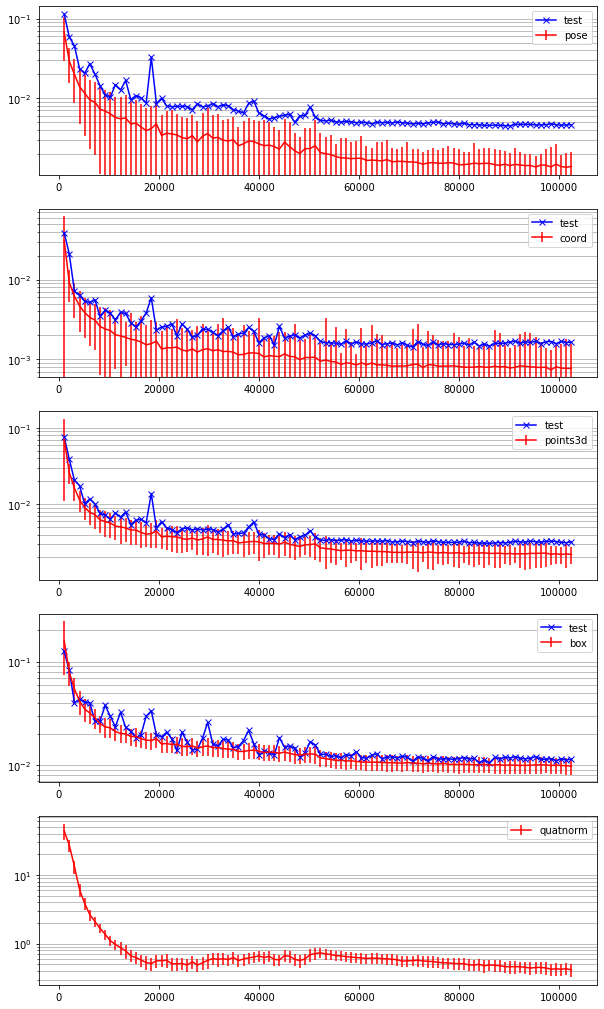

Finished Training


In [9]:
%matplotlib inline
pyplot.ioff()

optimizer = optim.Adam(net.parameters(), lr=1.e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [50], gamma=0.1)

network_filename = None

n_epochs = 100

criterions = [
    train.QuatPoseLoss2(),
    train.CoordPoseLoss(),
    train.Points3dLoss(),
    train.BoxLoss(),
    train.QuaternionNormalizationRegularization(),
]
critweights = np.array([.4, .4, 0.2, 0.1, 1.e-5 ])

train.run_the_training(n_epochs,
                      optimizer,
                      net,
                      train_loader,
                      test_loader,
                      criterions,
                      critweights,
                      4,
                      join('..','model_files'),
                      network_filename,
                      other_metrics = [],
                      scheduler = scheduler)